# Exploring the Relative Entropy Monotone

In [1]:
using Plots, RTFOOL, Base.Test
gr()

Plots.GRBackend()

We start out by loading up energies for our system. Specifically, we will load the dissociated and liquid water energies into `Ew` and the monomer and dimer energies into `Em`.

In [2]:
Ew, Em = let E = readdlm("energies.dat")
    E[1:2], E[3:4]
end

([0.263758, -2.23803], [-3.43351, -2.18262])

**Note** We determined the energy of a dissociated water molecule in a *very* naive way:
$$
E_2 + E_{liq} = 2E_1 + E_{dis}
$$
This was mostly for simplicities sake. We'll use a more robust method for further investigation.

These energies are in electron-volts at $30^\circ C$, so we need to initialize $\beta$ accordingly.

In [3]:
const k = 8.6173303e-5 # eV/K
const T = 30 + 273.15  # 30° C in K
const β = k*T

0.026123436804449996

## Simple dimer example

We'll start out with our simple dimer example with $2$ dimers and $2$ water molecules.

In [4]:
const Nm, Nw = 2, 2;

### System StateSpace

In [5]:
sys = StateSpace(Em, Nm, Ew, Nw)

RTFOOL.StateSpace{4}(NTuple{4,Int64}[(2, 2, 2, 1), (1, 1, 1, 1)], [-6.33951, -6.33951], BigInt[2, 1])

We see that there are two macroscopic configurations: `(2,2,2,1)` and `(1,1,1,1)` which correspond to `dimer + liq + dis` and `2monomer + 2dis`, respectively. The energies of these macrostates are the same due to how we computed $E_{dis}$ (see previous section). However, the dimer macrostate has 2 microstates corresponding to the choice of which water molecule to dissociate. Strictly speaking, there is some amount of unenumerated degeneracy in the second macrostate corresponding the the choice of which water molecule to bind to which monomer, or even which hydrogen/hydroxide to bind to which monomer. We're neglecting this for now. It would be fairly straightforward to account for this.

### Thermalization Context

We now construct a thermalization `Context` in which to run our simulation. This will collect a system `StateSpace`, a system state (i.e. a distribution over the system's state), and a bath `StateSpace`. At construction, this will build the bath's Gibbs state, identify all of the possible swaps, and compute the probability of each swap.

In [6]:
ctx = Context(β, sys, [0.0, 1.0]);

Here we are using the same state space for both the system and the bath. We are starting our system out in the pure state with 2 free monomers. We can access the bath's state as

In [7]:
ctx.bath_state

2-element Array{Float64,1}:
 0.666667
 0.333333

Note that the bath state is not uniform despite the macrostates having the same energy; this is due to the configuration's distinct degeneracies. We can also access which states are admissible

In [8]:
ctx.degeneracies

1-element Array{Tuple{Tuple{Int64,Int64},Tuple{Int64,Int64}},1}:
 ((1, 2), (2, 1))

We will be changing the name of this field to `swaps` or something similar. The name at the moment makes explicit the point that swaps are determined by the degenerate composite system-bath states. We can in this case that there is exactly one admissible swap: `(1,2) ↔ (2,1)`. Each pair corresponds to a composite system-bath state. For example, `(1,2)` represents the tensor product state $e^s_1 \otimes e^b_2$ where $e^s_i$ and $e^b_j$ are pure states of the system and bath, respectively.

We can also determine the probability of choosing this swap. At first glance it appears that it should be unity. However, this neglects the possibility of applying an identity transformation. As such, the sum of the probabilities over the non-trivial swaps is not 1.0.

In [9]:
ctx.P

1-element Array{BigFloat,1}:
 3.333333333333333333333333333333333333333333333333333333333333333333333333333348e-01

We can access the probability of the identity transformation as

In [10]:
ctx.Pid

6.666666666666666666666666666666666666666666666666666666666666666666666666666695e-01

We would always have that

In [11]:
@assert sum(ctx.P) + ctx.Pid ≈ 1.0

### Thermalizing the System

We are now poised to thermalize the system over a period of time. At the moment, this is done via a a loop and a call to the `timestep` method. Let's thermalize for 10 timesteps.

Remember that the initial state of the system is:

In [12]:
ctx.system_state

2-element Array{Float64,1}:
 0.0
 1.0

In [13]:
let rng = MersenneTwister(2018) # we'll explicitly use a random number generator instead of the GLOBAL_RNG
    for _ in 1:10
        println(timestep(rng, ctx)) # if the rng is not provided, we fall back to the GLOBAL_RNG
    end
end

[0.0, 1.0]
[0.0, 1.0]
[0.666667, 0.333333]
[0.666667, 0.333333]
[0.666667, 0.333333]
[0.666667, 0.333333]
[0.666667, 0.333333]
[0.666667, 0.333333]
[0.666667, 0.333333]
[0.666667, 0.333333]


We can see that the identity transformation was applied during the first two timesteps. At the third timestep, the system thermalized a bit. In fact, it thermalized *completely*! This is a result of how simple our system is. A larger system **shouldn't** have this property. Let's test that out!

## Needs more Cowbell

Let's build a larger system, say $5$ monomers (limited to forming dimers) and $5$ water molecules:

In [14]:
sys = StateSpace(Em, 5, Ew, 5)
sys.basis, sys.energy, sys.deg

(NTuple{10,Int64}[(2, 2, 2, 2, 1, 2, 2, 1, 1, 1), (2, 2, 1, 1, 1, 2, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1)], [-15.8488, -15.8488, -15.8488], BigInt[150, 50, 1])

We have three macrostates (2 dimers + 1 monomer, 1 dimer + 3 monomers, 5 monomers). They all have the same energy, but they have different amounts of degeneracy.

In [15]:
ctx = Context(β, sys, [0,0,1]);

We start our thermalization with the system in the 5-monomer pure state. The bath's state looks like

In [16]:
ctx.bath_state

3-element Array{Float64,1}:
 0.746269  
 0.248756  
 0.00497512

And we have three admissible, non-trivial swaps:

In [17]:
ctx.degeneracies

3-element Array{Tuple{Tuple{Int64,Int64},Tuple{Int64,Int64}},1}:
 ((1, 2), (2, 1))
 ((1, 3), (3, 1))
 ((2, 3), (3, 2))

They are not all equally likely though!

In [18]:
Array{Float64}(ctx.P), Float64(ctx.Pid)

([0.15253, 6.1012e-5, 6.77911e-6], 0.8474021624828691)

Our system has an $84.7\%$ chance of staying where it is at any given timestep. Since we are starting out in a very unlikely state, and it is so small, it is going to be difficult for us to leave!! **I suspect this is why we are hardpressed to build long polymers from systems of free monomers!!**

Let's see how this goes. We'll start by simulating $10$ timesteps, as before.

In [19]:
srand(2018)
for _ in 1:10
    println(timestep(ctx))
end

[0.0, 0.0, 1.0]
[0.0, 0.0, 1.0]
[0.0, 0.0, 1.0]
[0.0, 0.0, 1.0]
[0.0, 0.0, 1.0]
[0.0, 0.0, 1.0]
[0.0, 0.0, 1.0]
[0.0, 0.0, 1.0]
[0.0, 0.0, 1.0]
[0.0, 0.0, 1.0]


As expected, we're sorta stuck. Let's simulate for much, much longer and see if we escape.

In [20]:
for _ in 1:1000000 # 1 million time steps
    timestep(ctx)  # let's not print all of those 😉
end
ctx.system_state

3-element Array{Float64,1}:
 0.746269  
 0.248756  
 0.00497512

Look at that! That's looking awfully similar to the bath's state! Let's see how similar.

In [21]:
re = Monotones.relative_entropy(ctx.system_state, ctx.bath_state)

6.661338147750942e-16

Alright, let's see about plotting some monotones, shall we?

### Monotones!!!

We'll start back in the 5-monomer pure state, calculate the relative entropy between the system state and bath state at each time step, and stop after it becomes sufficiently small ($\leq 1.0 \times 10^{-9}$). We keep an array of the sequence of relative entropies that differ, together with an array of the number of times the entropy appears consecutively. This condenses our plots a bit.

In [22]:
@time begin
    srand(2018)
    ctx.system_state[:] = let state = zeros(ctx.system_state)
        state[end] = 1.0
        state
    end
    re = [Monotones.relative_entropy(ctx.system_state, ctx.bath_state)]
    nre = [1]
    t = 0
    while re[end] > 1e-9
        timestep(ctx)
        r = Monotones.relative_entropy(ctx.system_state, ctx.bath_state)
        if r ≈ re[end]
            nre[end] += 1
        else
            push!(re, r)
            push!(nre, 1)
        end
        t += 1
    end
    println("Simulated for $t timesteps with $(length(re)) stretches")
end

Simulated for 168963 timesteps with 30 stretches
  0.192986 seconds (2.44 M allocations: 60.223 MiB, 8.23% gc time)


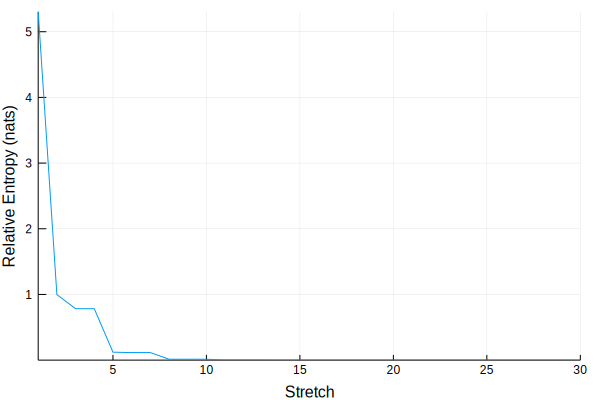

In [23]:
plot(re, xlabel="Stretch", ylabel="Relative Entropy (nats)", legend=false)

Now let's ensure that the relative entropy is actually monotonic.

In [24]:
for i in 2:length(re)
    @test isapprox(re[i], re[i-1]; atol=1e-10) || re[i] < re[i-1]
end

## BIGGER!!!

Let's give it a go with 5 monomers and 13 water molecules! (**Note** there's a *chance* that the results will be incorrect. It is difficult to check results or such large systems.)

In [25]:
sys = StateSpace(Em, 5, Ew, 13)

system_state = let state = zeros(Float64, length(sys))
    state[end] = 1.0
    state
end

ctx = Context(β, sys, system_state)

println("There are $(length(sys)) macrostates and $(length(ctx.degeneracies)) non-trivial swaps.")
@printf "The probability of the identity swap is ∼%0.3f." ctx.Pid

There are 3 macrostates and 3 non-trivial swaps.
The probability of the identity swap is ∼0.706.

In [26]:
@time begin
    srand(2018)
    re = [Monotones.relative_entropy(ctx.system_state, ctx.bath_state)]
    nre = [1]
    t = 0
    while re[end] > 1e-9
        timestep(ctx)
        r = Monotones.relative_entropy(ctx.system_state, ctx.bath_state)
        if r ≈ re[end]
            nre[end] += 1
        else
            push!(re, r)
            push!(nre, 1)
        end
        t += 1
    end
    println("Simulated for $t timesteps with $(length(re)) stretches")
end

Simulated for 426 timesteps with 57 stretches
  0.029633 seconds (13.45 k allocations: 572.669 KiB)


In [27]:
for i in 2:length(re)
    @test isapprox(re[i], re[i-1]; atol=1e-10) || re[i] < re[i-1]
end

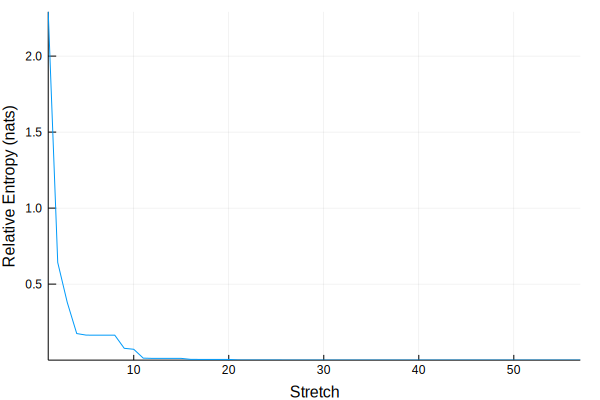

In [28]:
plot(re, xlabel="Stretch", ylabel="Relative Entropy (nats)", legend=false)

## Still BIGGER!!!

In [29]:
sys = StateSpace(Em, 5, Ew, 14)

system_state = let state = zeros(Float64, length(sys))
    state[end] = 1.0
    state
end

ctx = Context(β, sys, system_state)

println("There are $(length(sys)) macrostates and $(length(ctx.degeneracies)) non-trivial swaps.")
@printf "The probability of the identity swap is ∼%0.3f." ctx.Pid

There are 3 macrostates and 5 non-trivial swaps.
The probability of the identity swap is ∼0.612.

In [30]:
@time begin
    srand(2018)
    re = [Monotones.relative_entropy(ctx.system_state, ctx.bath_state)]
    nre = [1]
    t = 0
    while re[end] > 1e-9
        timestep(ctx)
        r = Monotones.relative_entropy(ctx.system_state, ctx.bath_state)
        if r ≈ re[end]
            nre[end] += 1
        else
            push!(re, r)
            push!(nre, 1)
        end
        t += 1
    end
    println("Simulated for $t timesteps with $(length(re)) stretches")
end

Simulated for 1995202 timesteps with 745123 stretches
  2.425325 seconds (33.20 M allocations: 877.461 MiB, 13.00% gc time)


In [31]:
for i in 2:length(re)
    @test isapprox(re[i], re[i-1]; atol=1e-10) || re[i] < re[i-1]
end

Test Failed
  Expression: isapprox(re[i], re[i - 1]; atol=1.0e-10) || re[i] < re[i - 1]


LoadError: [91mThere was an error during testing[39m

Uh, oh! It looks like we're having some problems when the number of water molecules gets too large. This could be an issue with the degeneracies getting to large, the probabilities getting too small, or both! More exploration to follow.

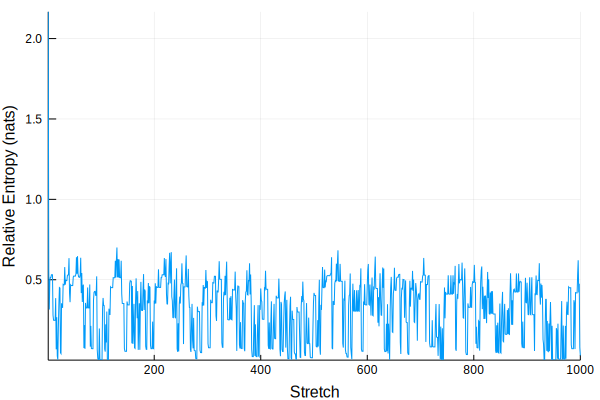

In [32]:
plot(re[1:1000], xlabel="Stretch", ylabel="Relative Entropy (nats)", legend=false)